In [413]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from tableone import TableOne, load_dataset
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

#### Setting data generation parameters

In [414]:
n = 2000  # size of each sample
sims = 100  # number of repeated samples
np.random.seed(1015033030)

#### Generating data

In [415]:
ids = []  # Generating simulation IDs
for i in range(sims):
    ids.extend([i + 1] * n)

df = pd.DataFrame()
df['sim_id'] = ids

In [416]:
# Creating confounders
df['age'] = np.round(np.random.normal(65, 10, size=n * sims), 0)  
df['crcl_log'] = np.random.normal(np.log(110), 0.18, size=n * sims) - 0.005 * df['age']
df['diabetes'] = np.random.binomial(n=1, p=st.logistic.cdf(-6.73 + 0.03 * df['crcl_log'] + 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims)
df['insulin'] = np.where(df['diabetes']==1,
                    np.random.binomial(n=1, p=st.logistic.cdf(-4.16 + 0.04 * df['crcl_log'] - 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims),
                         0)
df['lvef'] = np.random.beta(11, 7, size=n * sims)*100 - 0.06 * df['age']
df['smoking'] = np.random.binomial(n=1, p=.21, size=n * sims)
df['pvd'] = np.random.binomial(n=1, p=st.logistic.cdf(-5.62 + 0.03 * df['smoking'] - 0.02 * df['age'] +
                                                        0.0009 * df['age'] ** 2), size=n * sims)
df['copd'] = np.random.binomial(n=1, p=st.logistic.cdf(-2.71 + 0.03 * df['smoking'] + 0.01 * df['pvd']), size=n * sims)
                                
df['tvd_lmcad'] = st.betabinom.rvs(2, .4, .7, loc=0, size=n * sims, random_state=None) #nb 0=3vd only, 1=lmad only, 2=both

# One-hot encoding
df['tvd'] = np.where(df['tvd_lmcad']==0, 1, 0)
df['lmcad'] = np.where(df['tvd_lmcad']==1, 1, 0)
df['both'] = np.where(df['tvd_lmcad']==2, 1, 0)

#### Define and run a function that generates anatomical SYNTAX scores

In [417]:
def sim_anat_syntax(tvd_lmcad):
    """simulate anatomic syntax scores from coronary disease type."""
    from zepid.sensitivity_analysis import trapezoidal
    
    dummy_mat=np.stack([tvd_lmcad==0, tvd_lmcad==1, tvd_lmcad==2], axis=1)
    
    tvd=trapezoidal(3,10,10,50, len(tvd_lmcad))
    lmcad=trapezoidal(4,20,20,50, len(tvd_lmcad))
    both=trapezoidal(7,10,30,60, len(tvd_lmcad))
    
    return(dummy_mat[:,0]*tvd + dummy_mat[:,1]*lmcad + dummy_mat[:,2]*both)

df['syntax']=sim_anat_syntax(df['tvd_lmcad'])

#### Plot the generated anatomical SYNTAX scores

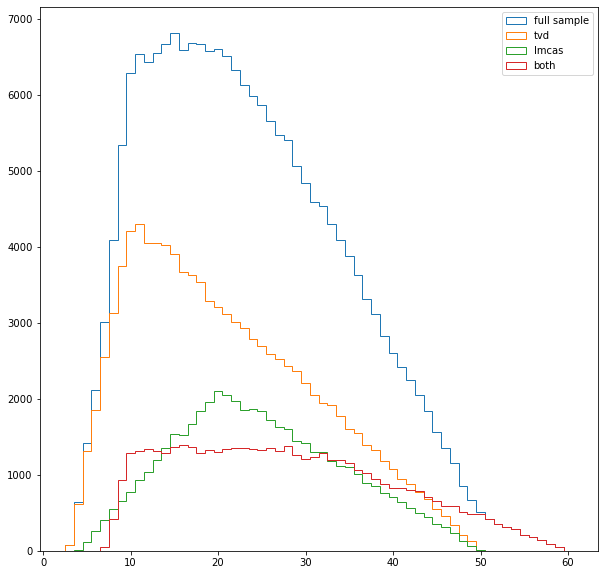

In [418]:
ind_tvd=df['tvd_lmcad']==0
ind_lmcad=df['tvd_lmcad']==1
ind_both=df['tvd_lmcad']==2

plt.figure(figsize=(10,10))
plt.hist(df['syntax'], histtype="step", bins=np.linspace(2.5,60.5, 59), label="full sample");
plt.hist(df['syntax'][ind_tvd], histtype="step", bins=np.linspace(2.5,60.5, 59), label="tvd");
plt.hist(df['syntax'][ind_lmcad], histtype="step", bins=np.linspace(2.5,60.5, 59), label="lmcas");
plt.hist(df['syntax'][ind_both], histtype="step", bins=np.linspace(2.5,60.5, 59), label="both");
plt.legend();

#### Plot LVEFs

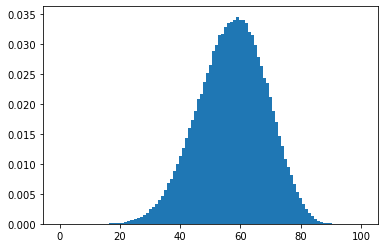

In [419]:
plt.hist(df.lvef, density=True, bins=np.linspace(-.5, 100.5, 102));

In [420]:
categorical = ['diabetes','insulin','smoking','pvd','copd','tvd_lmcad']
columns = ['age', 'crcl_log', 'diabetes', 'insulin', 'lvef', 'smoking', 'pvd','copd', 'tvd_lmcad']
#mytable = TableOne(df.iloc[0:n,:], columns = columns, categorical=categorical)
#print(mytable.tabulate(tablefmt="github"))

#### Treatment allocation mechanism (True Propensity Score)

In [421]:
df['cabg_pr'] = st.logistic.cdf(-2.971
                               + 0.049*(df['age'] - 30)
                               - 0.001*(df['age'] - 30)**2
                               + 0.212*df['crcl_log']
                               + 0.973*np.where(df['crcl_log'] > np.log(100), 1, 0)
                               - 0.386*df['copd']
                               # Treatment-assignment based on disease type
                               + 1.973*np.where(df['tvd_lmcad']==1, 1, 0)
                               + 2.973*np.where(df['tvd_lmcad']==2, 1, 0)
                               )
df['cabg'] = np.random.binomial(n=1, p=df['cabg_pr'], size=n*sims)

#### Potential outcomes

In [422]:
prY1 = st.logistic.cdf(-21.54
                    # Treatment effect
                    - 0.04
                    - 0.12 * (df['tvd_lmcad']==0) + 1.5 * (df['tvd_lmcad']==1) - 1.1 * (df['tvd_lmcad']==2)
                    - 0.05 * df['syntax']
                    
                    # Other effects
                    + 0.31 * np.sqrt(df['age'])
                    - 0.04 * df['crcl_log']
                    + 0.29 * df['diabetes']
                    + 0.29 * df['insulin']
                    + 0.29 * df['lvef']
                    + 0.29 * df['smoking']
                    + 0.29 * df['pvd']
                    + 0.29 * df['copd']
                    + 0.09 * (df['tvd_lmcad']==0) + 0.07 * (df['tvd_lmcad']==1) + 0.12 * (df['tvd_lmcad']==2)
                    + 0.14 * np.where(df['lvef'] < 20, df['lvef']**.5, 0)
                    )
df['Y1'] = np.random.binomial(n=1, p=prY1, size=n*sims)

prY0 = st.logistic.cdf(-21.54
                    # Other effects
                    + 0.31 * np.sqrt(df['age'])
                    - 0.04 * df['crcl_log']
                    + 0.29 * df['diabetes']
                    + 0.29 * df['insulin']
                    + 0.29 * df['lvef']
                    + 0.29 * df['smoking']
                    + 0.29 * df['pvd']
                    + 0.29 * df['copd']
                    + 0.09 * (df['tvd_lmcad']==0) + 0.07 * (df['tvd_lmcad']==1) + 0.12 * (df['tvd_lmcad']==2)
                    + 0.14 * np.where(df['lvef'] < 20, df['lvef']**.5, 0)
                    )
df['Y0'] = np.random.binomial(n=1, p=prY0, size=n*sims)
df['Y'] = np.where(df['cabg'] == 1, df['Y1'], df['Y0'])  # causal consistency

df['true_cate'] = prY1 - prY0
df.head()

,sim_id,age,crcl_log,diabetes,insulin,lvef,smoking,pvd,copd,tvd_lmcad,tvd,lmcad,both,syntax,cabg_pr,cabg,Y1,Y0,Y,true_cate
0,1,59.0,4.488383,0,0,61.411709,1,0,0,1,0,1,0,30.765774,0.630308,0,0,1,1,-0.013866
1,1,54.0,4.422784,0,0,54.682434,0,0,0,1,0,1,0,12.625054,0.631726,0,0,0,0,0.035029
2,1,58.0,4.633855,0,0,59.718083,1,0,0,1,0,1,0,31.664024,0.824245,0,0,0,0,-0.015565
3,1,60.0,4.366004,0,0,63.140444,0,0,0,2,0,0,1,25.026275,0.817215,1,0,0,0,-0.256152
4,1,56.0,4.448854,0,0,68.151808,0,0,0,2,0,0,1,38.683772,0.823923,1,1,1,1,-0.549244


In [423]:
categorical = ['Y','diabetes','insulin','smoking','pvd','copd','tvd_lmcad']
columns = ['Y', 'age', 'crcl_log', 'diabetes', 'insulin', 'lvef', 'smoking', 'pvd','copd', 'tvd_lmcad', 'syntax']
mytable = TableOne(df.iloc[0:n,:], columns = columns, categorical = categorical, groupby = "cabg")
print(mytable.tabulate(tablefmt="github"))

|                     |    | Missing   | Overall     | 0           | 1           |
|---------------------|----|-----------|-------------|-------------|-------------|
| n                   |    |           | 2000        | 1153        | 847         |
| Y, n (%)            | 0  | 0         | 1545 (77.2) | 847 (73.5)  | 698 (82.4)  |
|                     | 1  |           | 455 (22.8)  | 306 (26.5)  | 149 (17.6)  |
| age, mean (SD)      |    | 0         | 65.5 (10.4) | 66.0 (10.8) | 64.9 (9.6)  |
| crcl_log, mean (SD) |    | 0         | 4.4 (0.2)   | 4.4 (0.2)   | 4.4 (0.2)   |
| diabetes, n (%)     | 0  | 0         | 1474 (73.7) | 845 (73.3)  | 629 (74.3)  |
|                     | 1  |           | 526 (26.3)  | 308 (26.7)  | 218 (25.7)  |
| insulin, n (%)      | 0  | 0         | 1789 (89.5) | 1024 (88.8) | 765 (90.3)  |
|                     | 1  |           | 211 (10.5)  | 129 (11.2)  | 82 (9.7)    |
| lvef, mean (SD)     |    | 0         | 57.1 (11.0) | 56.9 (11.2) | 57.4 (10.8) |
| sm

#### Define Syntax 2020 Model for predicting risk of all-cause death at 10 years
 as defined in Takahashi et al. Lancet 2020. Table 2

In [424]:
def syntax2020(age, crcl, lvef, copd, pvd, diabetes, insulin, smoking, tvd, lmcad, syntax, cabg):
    return 1-np.exp(-0.243 *np.exp(0.99 * (0.72*age/10 - 0.07 * np.where(crcl<90, crcl ,90)/10 -0.31 * np.where(lvef<50, lvef, 50)/10 + 0.48 * copd + 0.73 * pvd + 0.20 * diabetes 
                    + 0.46 * insulin + 0.66 * smoking)
                    - 0.4 * cabg * tvd - 0.07 * cabg * lmcad - 0.1 * (1 - cabg) * lmcad + .16 * (1-cabg) * (syntax - 29)/10 -2.80))

In [425]:
syntax2020(age=74, crcl=38.6, lvef=40, copd=0, pvd=0, diabetes=0, insulin=0, smoking=1, tvd=0, lmcad=1, syntax=11, cabg=0)

0.5699878103841629

In [426]:
df['pred_cabg']=df.apply(lambda row : syntax2020(age=row['age'], crcl=np.exp(row['crcl_log']), lvef=row['lvef'],
                                copd=row['copd'], pvd=row['pvd'], diabetes=row['diabetes'],
                                 insulin=row['insulin'], smoking=row['smoking'], tvd=row['tvd_lmcad']==0,
                                 lmcad=row['tvd_lmcad']==1, syntax=row['syntax'],
                                 cabg=1), axis = 1)

df['pred_pci']=df.apply(lambda row : syntax2020(age=row['age'], crcl=np.exp(row['crcl_log']), lvef=row['lvef'],
                                copd=row['copd'], pvd=row['pvd'], diabetes=row['diabetes'],
                                 insulin=row['insulin'], smoking=row['smoking'], tvd=row['tvd_lmcad']==0,
                                 lmcad=row['tvd_lmcad']==1, syntax=row['syntax'],
                                 cabg=0), axis = 1)

df['pred_cate'] = df['pred_cabg'] - df['pred_pci']

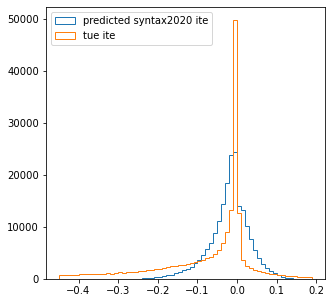

In [427]:
plt.figure(figsize=(5,5))
plt.hist(df['pred_cate'], histtype="step", bins=np.arange(-.45,.2, .01), label="predicted syntax2020 ite");
plt.hist(df['true_cate'], histtype="step", bins=np.arange(-.45,.2, .01), label="tue ite");
plt.legend(loc=2);

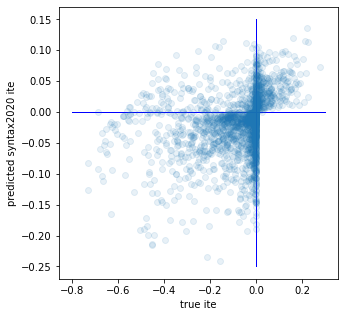

In [428]:
df_1 = df[df.sim_id==1]

plt.figure(figsize=(5,5))
plt.plot([-.8,.3], [0,0], "b-", linewidth=1);
plt.plot([0,0], [-.25,.15], "b-", linewidth=1);
plt.plot(df_1['true_cate'], df_1['pred_cate'], "o", alpha=.1);
plt.xlabel('true ite');
plt.ylabel('predicted syntax2020 ite');

#### Predict all-cause death at 10 years for our simulated patients from the reported models
 `coef_mod1` and `coef_mod2` are from Takahashi et al. Lancet 2020. Table 2.

In [429]:
def syntax_iHR(df):
    """get individualized HR from SYNTAX 2020"""
    coef_mod2=np.array([0.99, -0.40, -0.08, -0.10, 0.16])
    X_cabg=np.stack([np.repeat(99,len(df)), 1* (df.tvd_lmcad==0), 1* (df.tvd_lmcad==1), 0 * np.array(df.tvd_lmcad==1), 0 * (df.syntax-29) / 10]).T # NB PIs don't contribute as it cancel out
    X_pci=np.stack([np.repeat(99,len(df)), 0* (df.tvd_lmcad==0), 0* (df.tvd_lmcad==1), 1 * np.array(df.tvd_lmcad==1), 1 * (df.syntax-29) / 10]).T  # in the substraction (here set at 99)
    X_diff=X_cabg-X_pci
    log_iHR = np.matmul(X_diff, coef_mod2)
    df['pred_hr'] = np.exp(log_iHR)
    return df

df = syntax_iHR(df)

#### Plot the predicted individualized HRs for our simulated patients

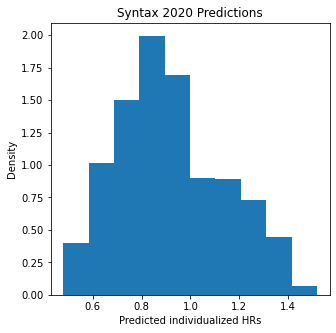

In [430]:
plt.figure(figsize=(5,5))
plt.hist(df['pred_hr'], density=True);
plt.title('Syntax 2020 Predictions');
plt.xlabel("Predicted individualized HRs");
plt.ylabel("Density");

In [431]:
def syntax_iHR_ci(df, alpha=.05):
    """Get individualized HR and 1-alpha CI from SYNTAX 2020"""
    
    coef_mod2=np.array([0.99, -0.40, -0.08, -0.10, 0.16])
    VCOV=np.array(  [[3.17E-03, -1.58E-04, -2.68E-04,2.56E-04,-3.78E-04],
                     [-1.58E-04,1.53E-02,6.56E-03,6.48E-03,1.45E-04],
                     [-2.68E-04,6.56E-03,1.68E-02,6.47E-03,1.62E-04],
                     [2.56E-04,6.48E-03,6.47E-03,1.75E-02,-1.08E-03],
                     [-3.78E-04,1.45E-04,1.62E-04,-1.08E-03,2.84E-03]])
    
    X_cabg=np.stack([np.repeat(99,len(df)), 1* (df.tvd_lmcad==0), 1* (df.tvd_lmcad==1), 0 * np.array(df.tvd_lmcad==1), 0 * (df.syntax-29) / 10]).T # NB PIs don't contribute as it cancel out
    X_pci=np.stack([np.repeat(99,len(df)), 0* (df.tvd_lmcad==0), 0* (df.tvd_lmcad==1), 1 * np.array(df.tvd_lmcad==1), 1 * (df.syntax-29) / 10]).T # in the substraction (here set at 99)
    X_diff=X_cabg-X_pci
    log_iHR = np.matmul(X_diff, coef_mod2)
    df_temp = df 
    df_temp['pred_hr'] = np.exp(log_iHR)
    
    log_iHR_se=X_diff.dot(VCOV).dot(X_diff.T).diagonal()
    
    temp = np.stack( [log_iHR, log_iHR-st.norm.ppf(1-alpha/2)*log_iHR_se, log_iHR+st.norm.ppf(1-alpha/2)*log_iHR_se])
    iHR_CI = np.exp(temp.T)
    df_temp['iHR']= iHR_CI[:,0]
    df_temp['iHR_lb']= iHR_CI[:,1]
    df_temp['iHR_ub']= iHR_CI[:,2]
    
    significant = ((df_temp['iHR_lb']<1) == (df_temp['iHR_ub']<1))
    
    df_temp['significance'] = significant
    
    return df_temp

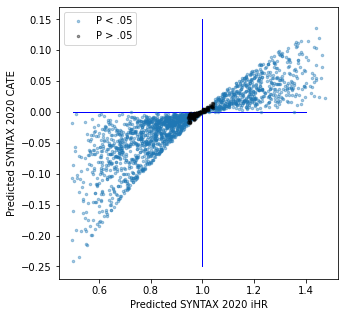

In [432]:
df_1 = df[df.sim_id==1]
df_1 = syntax_iHR_ci(df_1)

plt.figure(figsize=(5,5))
plt.plot([.5,1.4], [0,0], "b-", linewidth=1);
plt.plot([1,1], [-.25,.15], "b-", linewidth=1);
plt.plot(df_1['iHR'][df_1['significance']], df_1['pred_cate'][df_1['significance']], 'o', markersize=2.5, alpha=.4, label="P < .05");
plt.plot(df_1['iHR'][~df_1['significance']], df_1['pred_cate'][~df_1['significance']],'ko', markersize=2.5, alpha=.4, label="P > .05");
plt.xlabel("Predicted SYNTAX 2020 iHR")
plt.ylabel("Predicted SYNTAX 2020 CATE");
plt.legend();

#### Define a function for PS and CATE estimation
- Propensity score is fitted through random forrest (1000 bootstrap aggregation & $ \sqrt{p} $ random sample of predictiors)
- CATE are estimated via T-learner with random forrest as base learners
- All models include all relevant variables and no others

In [433]:
def ps_pr_preds(df, progress=1):
    
    from sklearn.ensemble import RandomForestClassifier
    ps_predictors = ["age", "crcl_log", "copd", "tvd", "lmcad", "both"]
    pronostic_predictors = ["tvd", "lmcad", "both", "syntax", "age", "crcl_log", "diabetes", "insulin", "lvef", "smoking", "pvd", "copd"]

    ps_mod = RandomForestClassifier(n_estimators=1000)
    ps_mod = ps_mod.fit(df[ps_predictors], df["cabg"])
    e_hat = ps_mod.predict_proba(df[ps_predictors])[:,1]

    pr_mod = RandomForestClassifier(n_estimators=1000)
    
    pr_mod1 = pr_mod.fit(df[df['cabg']==1].loc[:,pronostic_predictors], df[df['cabg']==1].loc[:,"Y"])
    y1_hat = pr_mod1.predict_proba(df.loc[:,pronostic_predictors])[:,1]
    
    pr_mod0 = pr_mod.fit(df[df['cabg']==0].loc[:,pronostic_predictors], df[df['cabg']==0].loc[:,"Y"])
    y0_hat = pr_mod0.predict_proba(df.loc[:,pronostic_predictors])[:,1]

    cate_hat = y1_hat-y0_hat
    
    df_temp = df
    df_temp["e_hat"] = e_hat
    df_temp["cate_hat"] = cate_hat
    
    if progress % 10 == 0:
        print(progress)
    return df_temp

In [434]:
df.iloc[:5,:15]

,sim_id,age,crcl_log,diabetes,insulin,lvef,smoking,pvd,copd,tvd_lmcad,tvd,lmcad,both,syntax,cabg_pr
0,1,59.0,4.488383,0,0,61.411709,1,0,0,1,0,1,0,30.765774,0.630308
1,1,54.0,4.422784,0,0,54.682434,0,0,0,1,0,1,0,12.625054,0.631726
2,1,58.0,4.633855,0,0,59.718083,1,0,0,1,0,1,0,31.664024,0.824245
3,1,60.0,4.366004,0,0,63.140444,0,0,0,2,0,0,1,25.026275,0.817215
4,1,56.0,4.448854,0,0,68.151808,0,0,0,2,0,0,1,38.683772,0.823923


In [435]:
df_1 = ps_pr_preds(df[df.sim_id==1])

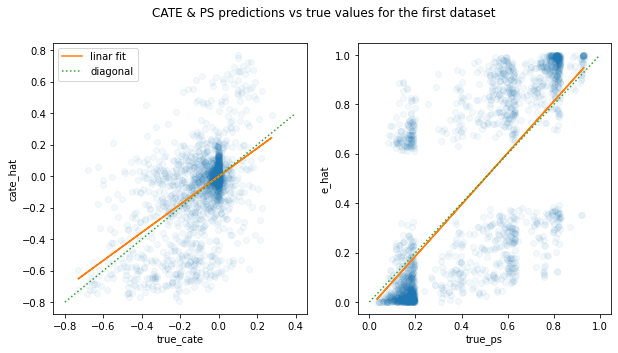

In [436]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('CATE & PS predictions vs true values for the first dataset')

ax1.plot(df_1["true_cate"], df_1["cate_hat"], "o", alpha=.05);
ax1.set_xlabel('true_cate')
ax1.set_ylabel('cate_hat')

m, b = np.polyfit(df_1["true_cate"], df_1["cate_hat"], 1)
ax1.plot(df_1["true_cate"], m*df_1["true_cate"] + b, label="linar fit")
ax1.plot([-.8,.4], [-.8,.4], linestyle=":", label="diagonal")
ax1.legend()


ax2.plot(df_1["cabg_pr"], df_1["e_hat"], "o", alpha=.05);
ax2.set_xlabel('true_ps')
ax2.set_ylabel('e_hat');

m, b = np.polyfit(df_1["cabg_pr"], df_1["e_hat"], 1)
ax2.plot(df_1["cabg_pr"], m*df_1["cabg_pr"] + b)
ax2.plot([0,1], [0,1], linestyle=":", label="diagonal");

#### Define functions for ARE and ASREs (three stochastic implementations as described below)

In [437]:
def compute_are_hat(df):
    """Compute ARE from a df where e_hat and cate_hat are provided"""
    are_hat = np.mean( ( (df.pred_cate<0) - df.e_hat)*df.cate_hat)
    return are_hat

In [438]:
def compute_r_asre_hat(df, alpha):
    """Compute uniform/random ASRE from a df where e_hat and cate_hat are provided
    alpha is the uniform/random parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = np.repeat(alpha, len(df))
    r_asre_hat = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.e_hat)*df_temp.cate_hat)
    return r_asre_hat

In [439]:
def compute_ci_asre_hat(df, alpha):
    """Compute CI ASRE from a df where e_hat and cate_hat are provided"""
    df_temp = syntax_iHR_ci(df, alpha)
    ci_asre_hat = np.mean( df_temp.significance * ( (df_temp.pred_cate<0) - df_temp.e_hat)*df_temp.cate_hat)
    return ci_asre_hat

In [440]:
def legit(x):
    return .5 * np.log((x+1)/(1-x))

def compute_cb_asre_hat(df, alpha):
    """Compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['e_hat']) ) ** legit(alpha)
    cb_asre_hat = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.e_hat)*df_temp.cate_hat)
    return cb_asre_hat

#### Estimate ARE and ASREs in each imputed dataset
##### I/ Create a list of datasets

In [441]:
inds = np.arange(sims)+1

df_list=[]
for i in inds:
    df_list.append(df[df['sim_id']==i])

##### II/ Fit PS & PR random forest models in all `sims` datasets
- Takes time in case of large number of datasets to analyze
- Implementation in C++ through a comprehensive list
- Seems faster than parrallelization through `from multiprocessing import Pool`

In [442]:
dfs_ready = [ps_pr_preds(data, progress) for progress, data in enumerate(df_list)]

0
10
20
30
40
50
60
70
80
90


##### III/ Now, all ARE / ASREs computations below are instantaneous..

In [443]:
are_hats = [compute_are_hat(i) for i in dfs_ready]

In [444]:
r_1_3_asre_hats = [compute_r_asre_hat(i, alpha=1/3) for i in dfs_ready]
r_2_3_asre_hats = [compute_r_asre_hat(i, alpha=2/3) for i in dfs_ready]

In [445]:
ci_95_asre_hats = [compute_ci_asre_hat(i, alpha=.05) for i in dfs_ready]
ci_55_asre_hats = [compute_ci_asre_hat(i, alpha=.45) for i in dfs_ready]

In [446]:
cb_1_3_asre_hats = [compute_cb_asre_hat(i, alpha=1/3) for i in dfs_ready]
cb_2_3_asre_hats = [compute_cb_asre_hat(i, alpha=2/3) for i in dfs_ready]

#### Import true values from `true_val.ipynb`

In [447]:
from ipynb.fs.full.true_val import true_are, true_1_3_r_asre, true_2_3_r_asre, true_95_ci_asre, true_55_ci_asre, true_1_3_cb_asre, true_2_3_cb_asre

#### Plot results

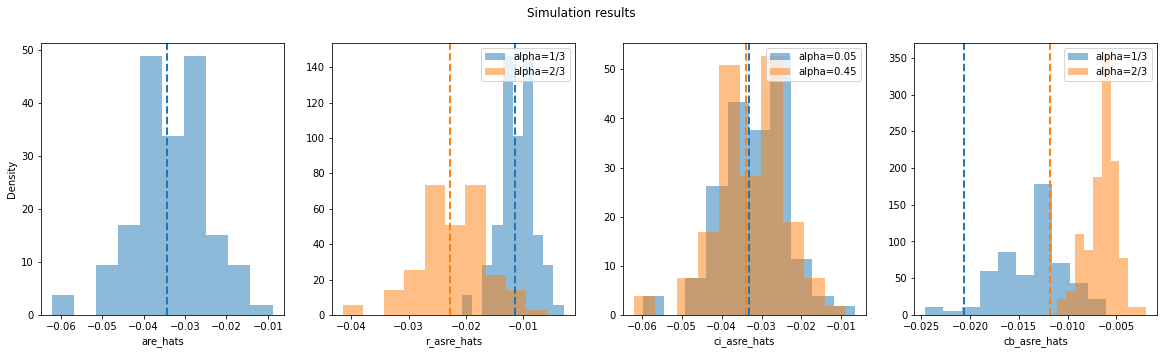

In [448]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

fig.suptitle('Simulation results')

ax1.hist(are_hats, density=True, alpha=.5);
ax1.set_xlabel('are_hats');
ax1.set_ylabel('Density');
ax1.axvline(true_are, color='tab:blue', linestyle='dashed', linewidth=2)

ax2.hist(r_1_3_asre_hats, density=True, alpha=.5, label="alpha=1/3");
ax2.axvline(true_1_3_r_asre, color='tab:blue', linestyle='dashed', linewidth=2)
ax2.hist(r_2_3_asre_hats, density=True, alpha=.5, label="alpha=2/3");
ax2.axvline(true_2_3_r_asre, color='tab:orange', linestyle='dashed', linewidth=2)
ax2.set_xlabel('r_asre_hats');
ax2.legend(loc='upper right')

ax3.hist(ci_95_asre_hats, density=True, alpha=.5, label="alpha=0.05");
ax3.axvline(true_95_ci_asre, color='tab:blue', linestyle='dashed', linewidth=2)
ax3.hist(ci_55_asre_hats, density=True, alpha=.5, label="alpha=0.45");
ax3.axvline(true_55_ci_asre, color='tab:orange', linestyle='dashed', linewidth=2)
ax3.set_xlabel('ci_asre_hats');
ax3.legend(loc='upper right')

ax4.hist(cb_1_3_asre_hats, density=True, alpha=.5, label="alpha=1/3");
ax4.axvline(true_1_3_cb_asre, color='tab:blue', linestyle='dashed', linewidth=2)
ax4.hist(cb_2_3_asre_hats, density=True, alpha=.5, label="alpha=2/3");
ax4.axvline(true_2_3_cb_asre, color='tab:orange', linestyle='dashed', linewidth=2)
ax4.set_xlabel('cb_asre_hats');
ax4.legend(loc='upper right');

#### Relation between alpha and ASRE in each of the three three stochastic implementation scenarios

In [449]:
alphas = np.linspace(.0001,.9999,1000)

r_asre_hat_alphas = [compute_r_asre_hat(dfs_ready[0], alpha) for alpha in alphas]
ci_asre_hat_alphas = [compute_ci_asre_hat(dfs_ready[0], alpha) for alpha in alphas]
cb_asre_hat_alphas =[compute_cb_asre_hat(dfs_ready[0], alpha) for alpha in alphas]

are_hat = compute_are_hat(dfs_ready[0])

In [450]:
def compute_ci_px(df, alpha):
    """Returns p(x)s for CI ASRE from a df
    alpha is type I error"""
    significance = syntax_iHR_ci(df, alpha)['significance']
    return significance

def compute_cb_px(df, alpha):
    """Returns p(x)s for compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['e_hat']) ) ** legit(alpha)
    return df_temp['p_x']

ci_mean_px_alphas = [np.mean(compute_ci_px(dfs_ready[0], alpha)) for alpha in alphas]
cb_mean_px_alphas = [np.mean(compute_cb_px(dfs_ready[0], alpha)) for alpha in alphas]

##### Compute true values fo ARE & ASREs

In [451]:
def compute_are_true(df):
    """Compute ARE from the true ps and cate"""
    are_true = np.mean( ( (df.pred_cate<0) - df.cabg_pr)*df.true_cate)
    return are_true

def compute_r_asre_true(df, alpha):
    """Compute uniform/random ASRE from the true ps and cate
    alpha is the uniform/random parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = np.repeat(alpha, len(df))
    r_asre_true = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return r_asre_true

def compute_ci_asre_true(df, alpha):
    """Compute CI ASRE from the true ps and cate"""
    df_temp = syntax_iHR_ci(df, alpha)
    ci_asre_true = np.mean( df_temp.significance * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return ci_asre_true

def compute_cb_asre_true(df, alpha):
    """Compute cognitive biais ASRE from the true ps and cate
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['cabg_pr']) ) ** legit(alpha)
    cb_asre_true = np.mean( df_temp.p_x * ( (df_temp.pred_cate<0) - df_temp.cabg_pr)*df_temp.true_cate)
    return cb_asre_true

are_true = compute_are_true(dfs_ready[0])
r_asre_alphas_true = [compute_r_asre_true(dfs_ready[0], alpha) for alpha in alphas]
ci_asre_alphas_true = [compute_ci_asre_true(dfs_ready[0], alpha) for alpha in alphas]
cb_asre_alphas_true = [compute_cb_asre_true(dfs_ready[0], alpha) for alpha in alphas]

##### Compute fraction of population following the rule under true cognitive biais (from true PS)

In [452]:
def compute_cb_px_true(df, alpha):
    """Returns p(x)s for compute cognitive biais ASRE from a df where e_hat and cate_hat are provided,
    alpha is the cognitive biais parameter (bounded between 0 and 1) """
    df_temp = df
    df_temp['p_x'] = (1 - np.abs( (df_temp['pred_cate']<0) - df_temp['cabg_pr']) ) ** legit(alpha)
    return df_temp['p_x']

cb_mean_px_alphas_true = [np.mean(compute_cb_px_true(dfs_ready[0], alpha)) for alpha in alphas]

##### Plot results

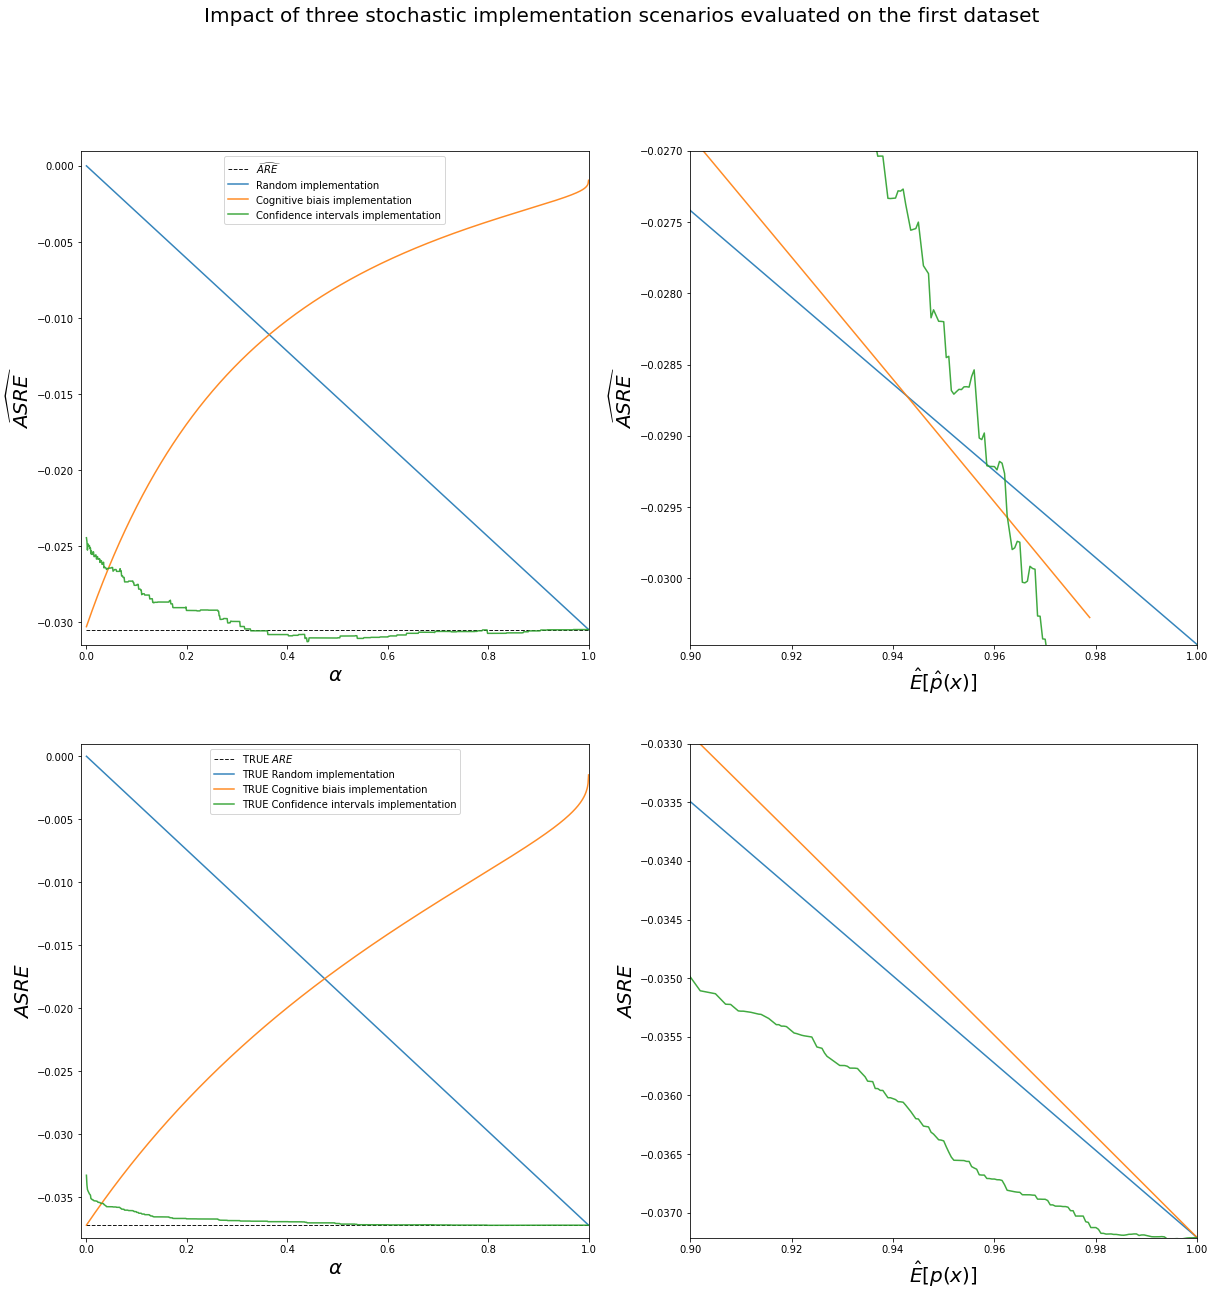

In [453]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))

fig.suptitle("Impact of three stochastic implementation scenarios evaluated on the first dataset", fontsize=20)
#ax1.plot([0,1],[0, 0], color= "black", alpha=1, linewidth=.5, linestyle='solid')

axs[0,0].plot([0,1],[are_hat, are_hat], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label=r'$\widehat{ARE}$')
axs[0,0].plot(alphas, r_asre_hat_alphas, color= "tab:blue", alpha=.9, label="Random implementation",)
axs[0,0].plot(alphas, cb_asre_hat_alphas, color= "tab:orange", alpha=.9, label="Cognitive biais implementation")
axs[0,0].plot(alphas, ci_asre_hat_alphas, color= "tab:green", alpha=.9, label="Confidence intervals implementation")

axs[0,0].set_xlabel(r'$\alpha$', fontsize=20)
axs[0,0].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)
axs[0,0].legend(loc='upper center');

axs[0,0].set_xlim([-.01,1])
axs[0,0].set_ylim([are_hat-.001,.001])

axs[1,0].plot([0,1],[are_true, are_true], color= "black", alpha=.9, linewidth=1, linestyle='dashed', label='TRUE $ARE$')
axs[1,0].plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
axs[1,0].plot(alphas, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
axs[1,0].plot(alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")

axs[1,0].set_xlabel(r'$\alpha$', fontsize=20)
axs[1,0].set_ylabel(r'$ASRE$', fontsize=20)
axs[1,0].legend(loc='upper center');

axs[1,0].set_xlim([-.01,1])
axs[1,0].set_ylim([are_true-.001,.001])

axs[0,1].plot(alphas, r_asre_hat_alphas, "-", alpha=.9)
axs[0,1].plot(cb_mean_px_alphas, cb_asre_hat_alphas, "-", alpha=.9)
axs[0,1].plot(ci_mean_px_alphas, ci_asre_hat_alphas, "-", alpha=.9)

axs[0,1].set_xlabel(r'$\hat{E}[\hat{p}(x)]$', fontsize=20)
axs[0,1].set_ylabel(r'$\widehat{ASRE}$', fontsize=20)

axs[0,1].set_xlim([.9,1])
axs[0,1].set_ylim([are_hat,-.027]);

axs[1,1].plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
axs[1,1].plot(cb_mean_px_alphas_true, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
axs[1,1].plot(ci_mean_px_alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")

axs[1,1].set_xlabel(r'$\hat{E}[p(x)]$', fontsize=20)
axs[1,1].set_ylabel(r'$ASRE$', fontsize=20)

axs[1,1].set_xlim([.9,1])
axs[1,1].set_ylim([are_true,-.033]);

##### Zoom out of the last figure
- Note that $ \hat{E}[p(x)] $ can be interpreted as the fraction of the population following the rule

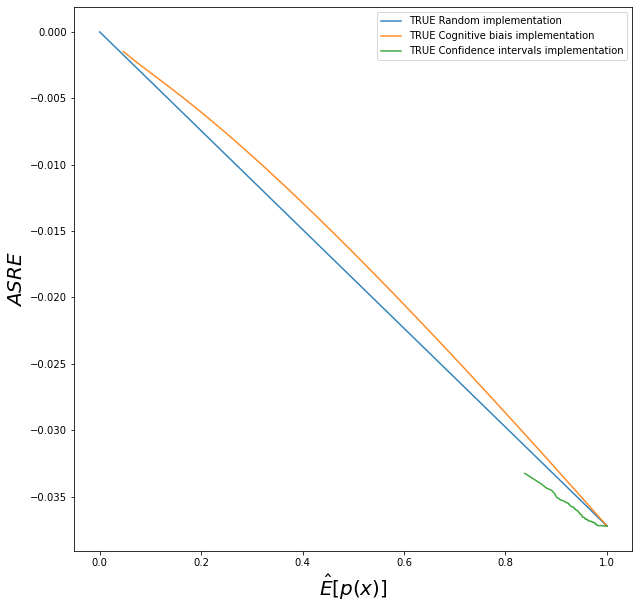

In [454]:
plt.figure(figsize=(10,10))
plt.plot(alphas, r_asre_alphas_true, color= "tab:blue", alpha=.9, label="TRUE Random implementation")
plt.plot(cb_mean_px_alphas_true, cb_asre_alphas_true, color= "tab:orange", alpha=.9, label="TRUE Cognitive biais implementation")
plt.plot(ci_mean_px_alphas, ci_asre_alphas_true, color= "tab:green", alpha=.9, label="TRUE Confidence intervals implementation")
plt.legend()

plt.xlabel(r'$\hat{E}[p(x)]$', fontsize=20)
plt.ylabel(r'$ASRE$', fontsize=20);

#### Bootstrap confidence intervals of ARE and ASREs
- Coverage check may be very computationally intensive
- Need further discussion with Raphaël Porcher and François Petit to define the best strategy...